# Advanced Lane Finding

### Imports

In [15]:
import pickle
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import HTML
from moviepy.editor import VideoFileClip

%matplotlib inline

### Camera Calibration
##### Use the calibration images to generate a calibration matrix for openCV

In [16]:
class Camera_Calibration():
    def __init__(self):
        self.calibrate()
        
    def calibrate(self):
        object_points = []
        image_points = []
        dummy_points = np.zeros((6*9, 3), np.float32)
        dummy_points[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

        image_paths = glob.glob('./camera_cal/calibration*.jpg')
        for path in image_paths:
            image = cv2.imread(path)
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
            if ret:
                object_points.append(dummy_points)
                image_points.append(corners)

        calibration_image = cv2.imread(image_paths[0])
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, calibration_image.shape[0:2], None, None)
        
        self.mtx = mtx
        self.dist = dist

### Distortion Correction

In [17]:
def correct_for_distortion(distorted, camera_calibration, save_output = False):    
    undistorted = cv2.undistort(distorted, camera_calibration.mtx, camera_calibration.dist, None, camera_calibration.mtx)

    if save_output:
        plt.imshow(cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB))       
        plt.savefig(output_path+'undistorted')
        
    return undistorted

### Color and Gradient Threshold

In [18]:
def region_of_interest(img):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    ysize = img.shape[0]
    xsize = img.shape[1]

    left_bottom = xsize - .05*xsize, ysize
    right_bottom = .05*xsize, ysize
    left_apex = xsize/2 - .05*xsize, .6*ysize
    right_apex = xsize/2 + .05*xsize, .6*ysize 
    vertices = np.array([[left_bottom, right_bottom, left_apex, right_apex]], dtype=np.int32)
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [19]:
def apply_threshold(image, s_thresh=(170, 255), sx_thresh=(40, 100), save_output=False):
    # Convert to HSV color space and separate the V channel
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS).astype(np.float)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    h_channel = hls[:,:,0]
  
    #Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))  
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    combined_binary_masked = region_of_interest(combined_binary)
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    if save_output: 
        #plt.imshow(color_binary)
        plt.imshow(combined_binary_masked, cmap='gray')
        plt.savefig(output_path+'combined_binary')
    return combined_binary_masked

### Perspective Transform

In [20]:
transform_src = np.float32([[382, 600], [500,517], [922, 600], [793, 517]])

transform_dst = np.float32([[441, 600], [441,517], [857, 600], [857, 517]])

In [21]:
def transform_perspective(gray, src, dst, save_output=False):
    img_size = (gray.shape[1], gray.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(gray, M, img_size)
    if save_output:
        plt.imshow(warped, cmap='gray')
        plt.savefig(output_path+'warped')
    return warped, M

### Identify Lane Lines

In [22]:
class Line():
    def __init__(self):
        self.initial_frame = True
        self.left_fit = None
        self.right_fit = None
        self.left_fitx = None
        self.right_fitx = None
        self.ploty = None
        self.left_curverad = None
        self.right_curverad = None
        self.center_offset = None
        
        self.all_left_fitx = []
        self.all_right_fitx = []
        
    def calculate(self, binary_warped, save_output=False):
        if self.initial_frame:
            self.__calculate_initial(binary_warped, save_output)            
            return 
        
        left_fit = self.left_fit
        right_fit = self.right_fit
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
        # Fit a second order polynomial to each
        left_fit_untested = np.polyfit(lefty, leftx, 2)
        right_fit_untested = np.polyfit(righty, rightx, 2)
        ploty_untested = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx_untested = left_fit_untested[0]*ploty_untested**2 + left_fit_untested[1]*ploty_untested + left_fit_untested[2]
        right_fitx_untested = right_fit_untested[0]*ploty_untested**2 + right_fit_untested[1]*ploty_untested + right_fit_untested[2]
       
        left_curverad, right_curverad, center_offset = self.__find_radius_of_curvature(binary_warped, left_fitx_untested, right_fitx_untested, ploty_untested)
        if self.__check_quality(left_fit_untested, right_fit_untested, left_fitx_untested, right_fitx_untested, left_curverad, right_curverad):
            self.left_fit = left_fit_untested
            self.right_fit = right_fit_untested
            self.ploty = ploty_untested
            self.left_fitx = left_fitx_untested
            self.right_fitx = right_fitx_untested
            self.left_curverad = left_curverad
            self.right_curverad = right_curverad
            self.center_offset = center_offset
            self.initial_frame = False
            self.all_left_fitx.append(left_fitx_untested)
            self.all_right_fitx.append(right_fitx_untested)
    
    def __check_quality(self, left_fit, right_fit, left_fitx, right_fitx, left_curverad, right_curverad):        
        # Reject if the two lines have a very different radius of curvature 
        if abs(left_curverad - right_curverad) > 500:
            return False
        # Reject if the lines are too far from paralell
        if abs((left_fit[0] - right_fit[0])/left_fit[0]) > 3:
            return False
        # Reject if any point on the polynomial is too far apart
        fit_difference = right_fitx - left_fitx
        if max(fit_difference) > 500 or min(fit_difference) < 350:
            return False
        return True
                
    def __calculate_initial(self, binary_warped, save_output=False):
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 10
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        left_curverad, right_curverad, center_offset = self.__find_radius_of_curvature(binary_warped, left_fitx, right_fitx, ploty)
        
        if save_output:
            out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
            out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
            plt.imshow(out_img)
            plt.plot(left_fitx, ploty, color='yellow')
            plt.plot(right_fitx, ploty, color='yellow')
            plt.xlim(0, 1280)
            plt.ylim(720, 0)
            plt.savefig(output_path+'sliding_windows')
        
        self.left_fit = left_fit
        self.right_fit = right_fit    
        self.left_fitx = left_fitx
        self.right_fitx = right_fitx
        self.ploty = ploty       
        self.left_curverad = left_curverad
        self.right_curverad = right_curverad
        self.center_offset = center_offset
        self.all_left_fitx.append(left_fitx)
        self.all_right_fitx.append(right_fitx)
        self.initial_frame = False
        
    def __find_radius_of_curvature(self, binary_warped, left_fitx, right_fitx, ploty):
        y_eval = np.max(ploty)
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

        camera_position = binary_warped.shape[1]/2
        lane_center = (left_fitx[719] + right_fitx[719])/2
        center_offset = abs(camera_position - lane_center) * xm_per_pix
        
        return left_curverad, right_curverad, center_offset

### Unwarp the image

In [23]:
def unwarp(warped, original, line, M, save_output=False):
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Smooth out the detections with an average of the last 5 fits
    if len(line.all_left_fitx) == 0:
        rolling_average_left = np.average(line.all_left_fitx[-5:], axis=0, weights=[1,2,3,4,5])
        rolling_average_right = np.average(line.all_right_fitx[-5:], axis=0, weights=[1,2,3,4,5])
    else:
        rolling_average_left = line.left_fitx
        rolling_average_right = line.right_fitx
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([rolling_average_left, line.ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([rolling_average_right, line.ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Find the inverse of the perspective matrix
    M_inv = np.linalg.inv(M)
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inv, (original.shape[1], original.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(original, 1, newwarp, 0.3, 0)
    
    # Add radius of curvature overlay 
    average_curverad = np.mean([line.left_curverad, line.right_curverad])
    text = "Radius " + str(average_curverad) + " m" + " Offset: " + str(line.center_offset)
    result = cv2.putText(result, text, (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
    
    if save_output:
        plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        plt.savefig(output_path+'unwarped_with_lanes')
        
    return result

### Pipeline

In [26]:
def pipeline(image, line, camera_calibration = None):
    if camera_calibration is None:
        camera_calibration = Camera_Calibration()
        
    undistorted = correct_for_distortion(image, camera_calibration)
    binary_image = apply_threshold(undistorted)
    top_down, M = transform_perspective(binary_image, transform_src, transform_dst)
    line.calculate(top_down)
    unwarped = unwarp(top_down, image, line, M, save_output = True)
    
    return unwarped

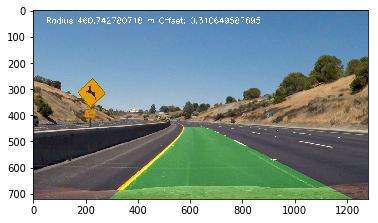

In [27]:
test_path = './test_images/'
output_path = './output_images/'

test_image = cv2.imread(test_path + 'test2.jpg')
line = Line()
test_output = pipeline(test_image, line)

### Apply Pipeline to Video

In [12]:
camera_calibration = Camera_Calibration()
line = Line()

project_output = 'test_videos_output/project_video.mp4'
clip1 = VideoFileClip("./project_video.mp4")
project_clip = clip1.fl_image(lambda t: pipeline(t, line, camera_calibration)) 
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [02:16<00:00,  9.22it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

Wall time: 2min 17s
